In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

'''
uncomment the lines below if test.png is not present in local device
NOTE: This requires gdown to be installed in your python environment. If not installed, install using:
pip install gdown
'''
# import gdown
# glink = 'https://drive.google.com/uc?id=1k4E2CLibF12PvUXMCwg3p0IATE8nzhHr'
# gdown.download(glink, output='test.png')


'\nuncomment the lines below if test.png is not present in local device\nNOTE: This required gdown to be installed in your python environment. If not installed, install using:\npip install gdown\n'

<b><h2>Question 1</h2></b>

In [2]:
class Kmeans_scratch:
    def __init__(self, n_init, max_iter, k, random_seed, tol=1e-4):
        #number of times cluster centers will be randomly initialised
        self.n_init = n_init
        #max number of iterations the cluster centers will be updated for
        self.max_iter = max_iter
        #number of clusters
        self.k = k
        #maximum accepted tolerance for two cluster centers to be considered equal
        self.tol = tol
        self.random_seed = random_seed
        #storing the lowest inertia value at the end
        self.inertia = None

        np.random.seed(self.random_seed)
        self.seed_list = np.random.randint(low=0, high=100000, size=self.n_init)


    #computing cluster center
    def computeCentroid(self, features):
        return np.mean(features, axis=0)
    
    
    #calculating inertia to compare best initialisation run
    def calc_inertia(self, dist):
        inertia = np.sum(np.min(dist, axis=1), dtype=np.float64)
        return inertia / dist.shape[0]
    

    #calculating distance between every pixel and every cluster center
    def calc_distance(self, x, cluster_centers):
        rows = x.shape[0]
        dist = np.empty([rows, self.k])
        dist = np.sqrt(np.sum((x[:, np.newaxis, :] - cluster_centers) ** 2, axis=2))

        return dist


    #updating cluster centers by categorically (label wise) finding out new cluster centers
    def update_cluster_centers(self, x, cluster_labels):
        updated_cluster = np.empty((self.k, x.shape[1]))

        for i in range(self.k):
            cluster_i_points = x[np.where(cluster_labels == i)[0]]
            updated_cluster[i, :] = self.computeCentroid(cluster_i_points)

        return updated_cluster


    #function which trains the model and eventually returns the best cluster centers
    #and labels with respect to the lowest inertia
    def mykmeans(self, x):
        cluster_centers_final = None
        set_cluster_idx_final = None

        #initialising cluster centers for n_init times
        for i in range(self.n_init):
            print(f'Init {i+1}')
            cluster_centers = np.empty((self.k, x.shape[1]))

            np.random.seed(self.seed_list[i])
            #choosing random cluster center for the first time in a run
            random_idx = np.random.randint(low=0, high=x.shape[0], size=self.k)
            cluster_centers = x[random_idx]
            set_cluster_idx = None
            temp_inertia = None

            for i in range(self.max_iter):
                #keeping old cluster centers for comparison
                old_cluster_centers = cluster_centers.copy()
                dist = self.calc_distance(x, cluster_centers)
                temp_inertia = self.calc_inertia(dist)
                
                #finding cluster center which is closest to every pixel
                set_cluster_idx = np.argmin(dist, axis=1)

                #updating new cluster center
                cluster_centers = self.update_cluster_centers(x, set_cluster_idx)

                #implementing converging criteria
                if np.linalg.norm(cluster_centers - old_cluster_centers) < self.tol:
                    print(f'Stopped at Iteration {i+1}')
                    break
            
            #updating inertia, cluster centers and labels if we have got lower
            #inertia value
            if (self.inertia == None) or (temp_inertia < self.inertia):
                self.inertia = temp_inertia
                cluster_centers_final = cluster_centers
                set_cluster_idx_final = set_cluster_idx

        return cluster_centers_final, set_cluster_idx_final

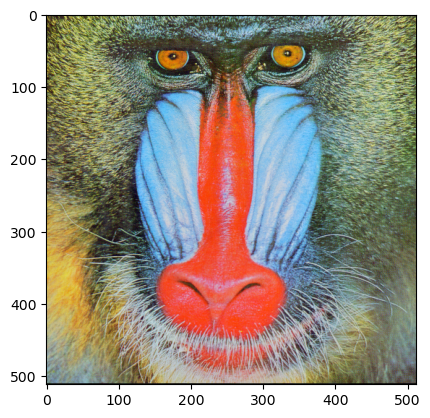

In [3]:
img = Image.open('test.png')
img_arr = np.array(img)
plt.imshow(img_arr)
plt.show()

In [4]:
img_reshape = img_arr.reshape(-1, 3)
#normalising pixel values to min = 0 and max = 1
img_reshape_norm = img_reshape / 255

Init 1
Stopped at Iteration 18
Init 2
Stopped at Iteration 11
Init 3
Stopped at Iteration 18
Init 4
Stopped at Iteration 10
Init 5
Stopped at Iteration 17
[[124  96  70]
 [155 173 171]]


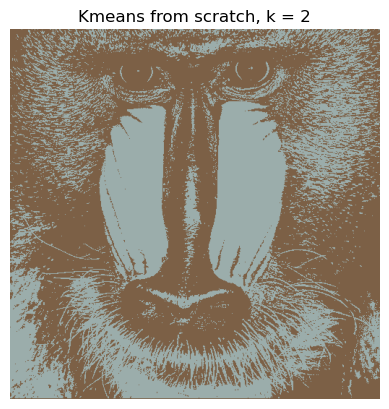

Init 1
Stopped at Iteration 41
Init 2
Stopped at Iteration 39
Init 3
Stopped at Iteration 42
Init 4
Stopped at Iteration 55
Init 5
Stopped at Iteration 57
[[227  95  60]
 [140 145 113]
 [152 184 202]
 [ 77  80  63]]


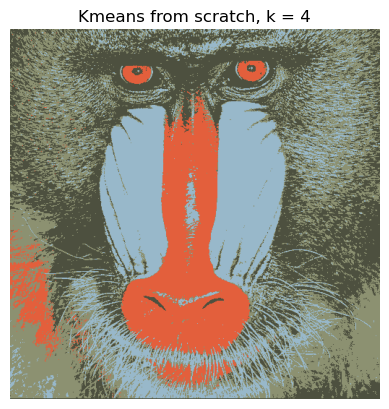

Init 1
Stopped at Iteration 29
Init 2
Stopped at Iteration 43
Init 3
Stopped at Iteration 63
Init 4
Stopped at Iteration 38
Init 5
Stopped at Iteration 40
[[108 121 103]
 [168 173 157]
 [232  83  57]
 [ 69  69  54]
 [178 156  86]
 [139 186 220]]


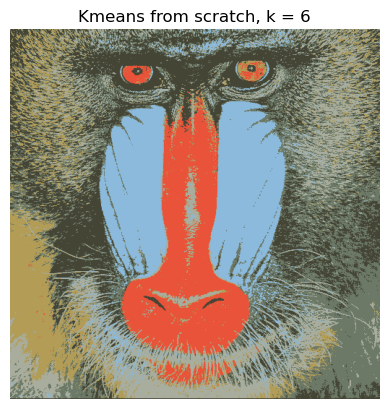

Init 1
Stopped at Iteration 54
Init 2
Stopped at Iteration 66
Init 3
Stopped at Iteration 40
Init 4
Stopped at Iteration 29
Init 5
Stopped at Iteration 58
[[232  83  56]
 [ 87  96  78]
 [ 58  55  45]
 [179 184 176]
 [132 125  80]
 [134 186 224]
 [187 164 101]
 [118 142 139]]


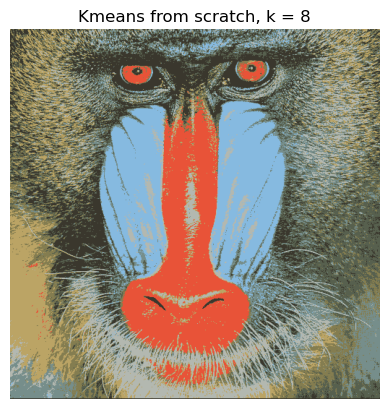

Init 1
Stopped at Iteration 130
Init 2
Stopped at Iteration 150
Init 3
Stopped at Iteration 163
Init 4
Stopped at Iteration 87
Init 5
Stopped at Iteration 136
[[ 57  53  44]
 [127 183 223]
 [132 126  80]
 [160 168 143]
 [234  78  44]
 [106 131 133]
 [222 106 107]
 [ 87  93  73]
 [181 193 197]
 [191 170  82]]


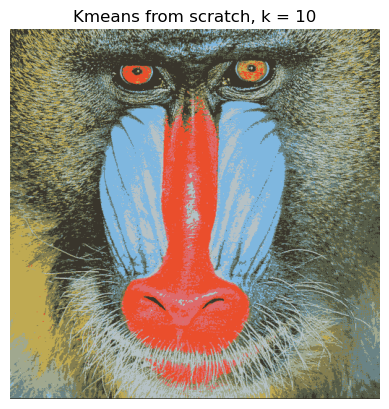

In [5]:
k_vals = [2, 4, 6, 8, 10]

for val in k_vals:
    kmeans = Kmeans_scratch(n_init=5,
                            max_iter=300,
                            k=val,
                            random_seed=123)

    cluster_centers, cluster_labels = kmeans.mykmeans(img_reshape_norm)
    print((cluster_centers * 255).astype(np.uint8))

    #getting segmented image with k colours only
    new_img = cluster_centers[cluster_labels]
    new_img = new_img.reshape(img_arr.shape)
    new_img = new_img * 255
    new_img = new_img.astype(np.uint8)
    plt.figure()
    plt.imshow(new_img)
    plt.title(f'Kmeans from scratch, k = {val}')
    plt.axis('off')
    # plt.savefig(f'images/kmeans_scratch_k{val}.png')
    plt.show()

<h3>Using scikit-learn's KMeans</h3>

[[124  96  70]
 [155 173 171]]


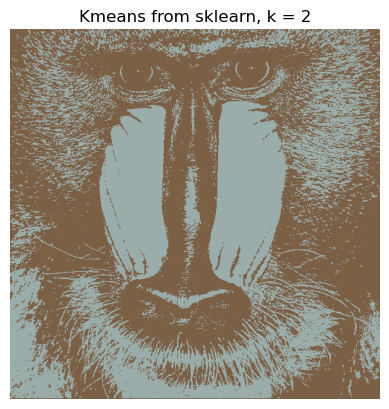

[[227  93  60]
 [152 184 203]
 [ 78  81  64]
 [142 147 114]]


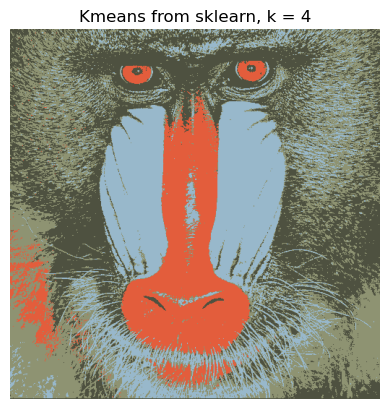

[[151 188 211]
 [106 110  81]
 [231  85  56]
 [183 166 114]
 [119 143 140]
 [ 63  62  50]]


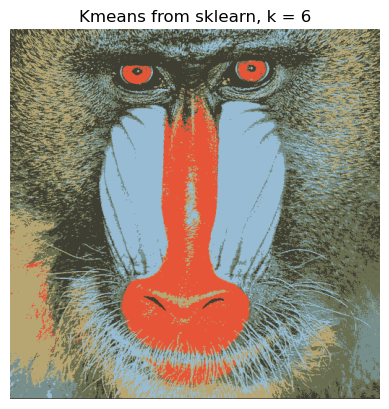

[[187 163  99]
 [135 187 224]
 [ 86  95  77]
 [232  83  56]
 [179 183 174]
 [129 125  82]
 [ 58  54  44]
 [117 142 141]]


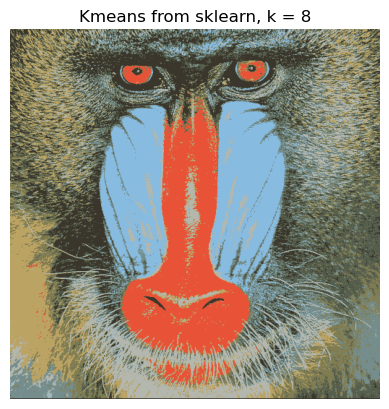

[[162 169 142]
 [130 126  82]
 [234  78  44]
 [181 193 197]
 [ 87  93  73]
 [106 132 136]
 [191 169  80]
 [222 106 107]
 [ 57  53  44]
 [127 184 223]]


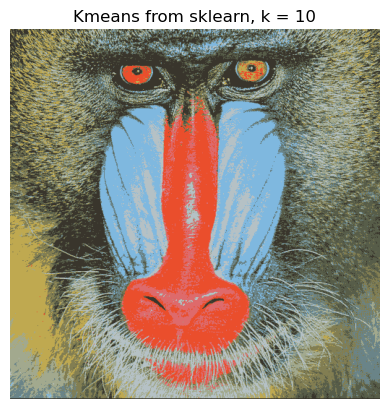

In [6]:
#using KMeans from sklearn
for val in k_vals:
    kmeans = KMeans(n_clusters=val, max_iter=300, n_init=5, random_state=123)
    kmeans.fit(img_reshape_norm)

    print((kmeans.cluster_centers_ * 255).astype(np.uint8))
    img_from_sklearn = kmeans.cluster_centers_[kmeans.labels_]
    img_from_sklearn = img_from_sklearn.reshape(img_arr.shape)
    img_from_sklearn = img_from_sklearn * 255
    img_from_sklearn = img_from_sklearn.astype(np.uint8)
    
    plt.figure()
    plt.imshow(img_from_sklearn)
    plt.title(f'Kmeans from sklearn, k = {val}')
    plt.axis('off')
    # plt.savefig(f'images/kmeans_sklearn_k{val}.png')
    plt.show()

<h3>Incorporating Spatial Coherence by considering original pixel coordinates</h3>

In [7]:
class Kmeans_spatial_coherence:
    def __init__(self, n_init, max_iter, k, rows, cols, random_seed, tol=1e-4):
        self.n_init = n_init
        self.max_iter = max_iter
        self.k = k
        #storing number of rows and columns in original image to assign
        #coordinates to every pixel
        self.r = rows
        self.c = cols
        self.tol = tol
        self.coord = None
        self.inertia = None
        self.random_seed = random_seed

        np.random.seed(self.random_seed)
        self.seed_list = np.random.randint(low=0, high=100000, size=self.n_init)

    #filling a 2D array with its corresponding 2D coordinates and then flattening it    
    def fill_coordinates(self):
        self.coord = np.empty((self.r, self.c, 2), dtype=np.float64)

        for i in range(self.r):
            for j in range(self.c):
                #min - max normalisation of coordinates
                self.coord[i][j][0] = (i / self.r)
                
                #assigning importance to coordinates for calculating distance
                #find more about this on the report
                self.coord[i][j][0] = self.coord[i][j][0] * np.sqrt(0.25)

                self.coord[i][j][1] = (j / self.c)
                self.coord[i][j][1] = self.coord[i][j][1] * np.sqrt(0.25)

        self.coord = self.coord.reshape(-1, 2)


    #stacking the flattened image and the coordinates in order to attain 
    #a matrix with 5 features (3 colours RGB + 2 coordinates X and Y)
    def stack_coords(self, x):
        stacked_arr = np.concatenate((x, self.coord[:, 0].reshape((-1, 1)), self.coord[:, 1].reshape((-1, 1))), axis=1)  
        return stacked_arr
    

    def computeCentroid(self, features):
        return np.mean(features, axis=0)
    
    
    def calc_inertia(self, dist):
        inertia = np.sum(np.min(dist, axis=1), dtype=np.float64)
        return inertia / dist.shape[0]
    

    #calculating euclidean distance by taking the 5 features
    def calc_distance(self, x, cluster_features):
        rows = x.shape[0]
        dist = np.empty([rows, self.k])
        dist = np.sqrt(np.sum((x[:, np.newaxis, :] - cluster_features) ** 2, axis=2))

        return dist


    def update_cluster_centers(self, x, cluster_labels):
        updated_cluster_feature = np.empty((self.k, x.shape[1]))

        for i in range(self.k):
            cluster_i_points = x[np.where(cluster_labels == i)[0]]
            updated_cluster_feature[i, :] = self.computeCentroid(cluster_i_points)

        return updated_cluster_feature


    def mykmeans(self, x):
        cluster_features_final = None
        set_cluster_idx_final = None

        self.fill_coordinates()
        
        #assinging feature importance to the colours (find more in report)
        x = x * np.sqrt(0.75)

        #updating x with a total of 5 features
        x = self.stack_coords(x)

        #the following contains same implementation as that of Kmeans_scratch class
        for i in range(self.n_init):
            print(f'Init {i+1}')

            np.random.seed(self.seed_list[i])
            random_idx = np.random.randint(low=0, high=x.shape[0], size=self.k)
            cluster_features = x[random_idx]
            set_cluster_idx = None
            temp_inertia = None

            for i in range(self.max_iter):
                old_cluster_features = cluster_features.copy()
                dist = self.calc_distance(x, cluster_features)
                temp_inertia = self.calc_inertia(dist)

                set_cluster_idx = np.argmin(dist, axis=1)
                cluster_features = self.update_cluster_centers(x, set_cluster_idx)

                #implement converging criteria over here
                if np.linalg.norm(cluster_features - old_cluster_features) < self.tol:
                    print(f'Stopped at Iteration {i+1}')
                    break
            
            if (self.inertia == None) or (temp_inertia < self.inertia):
                self.inertia = temp_inertia
                cluster_features_final = cluster_features
                set_cluster_idx_final = set_cluster_idx


        return cluster_features_final, set_cluster_idx_final

In [8]:
kmeans = Kmeans_spatial_coherence(n_init=5,
                                  max_iter=300,
                                  k=8,
                                  rows=512,
                                  cols=512,
                                  random_seed=123,
                                  tol=1e-4)

cluster_features, labels = kmeans.mykmeans(img_reshape_norm)


Init 1
Stopped at Iteration 42
Init 2
Stopped at Iteration 92
Init 3
Stopped at Iteration 64
Init 4
Stopped at Iteration 57
Init 5
Stopped at Iteration 56


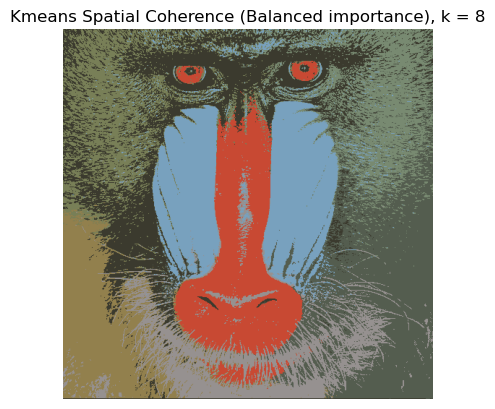

In [9]:
new_img = cluster_features[labels]
new_img = new_img[:, :3]

new_img = new_img.reshape(img_arr.shape)
new_img = new_img * 255
new_img = new_img.astype(np.uint8)
plt.figure()
plt.imshow(new_img)
plt.title(f'Kmeans Spatial Coherence (Balanced importance), k = 8')
plt.axis('off')
# plt.savefig(f'images/kmeans_spatial_coherence_balanced_k8.png')
plt.show()

<b><h2>Question 2</h2></b>

In [10]:
iris = datasets.load_iris(as_frame=True)
features = iris.data
y_vals = iris.target
labels = iris.target_names
labels

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [11]:
features

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]

In [12]:
df = pd.concat([features, y_vals], axis=1)
df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  
1         0  
2         0  
3         0  
4         0  
..      ...  
145       2  
146       2  
147       2  
148       2  
149       2  

[150 rows x 5 columns]

In [13]:
#taking only required features
x = df[['petal length (cm)', 'petal width (cm)', 'target']]
x = x[(x['target'] == 0) | (x['target'] == 1)]
x = x.reset_index(drop=True)

y = x['target']
x = x.drop(columns=['target'])
x

petal length (cm)  petal width (cm)
0                 1.4               0.2
1                 1.4               0.2
2                 1.3               0.2
3                 1.5               0.2
4                 1.4               0.2
..                ...               ...
95                4.2               1.2
96                4.2               1.3
97                4.3               1.3
98                3.0               1.1
99                4.1               1.3

[100 rows x 2 columns]

In [14]:
y

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: target, Length: 100, dtype: int32

In [15]:
x_arr = x.to_numpy()
y_arr = y.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=0.2, stratify=y, random_state=3)

#normalising features
sc = StandardScaler()
x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)

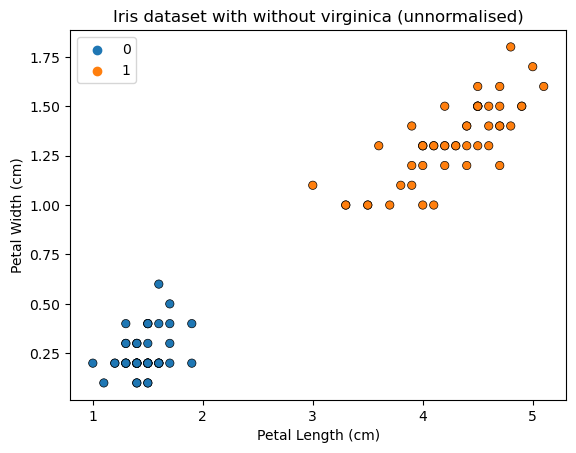

In [16]:
#plotting the whole dataset
sns.scatterplot(x=x_arr[:, 0],
                y=x_arr[:, 1],
                hue=y_arr,
                edgecolor='black')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
# plt.legend(labels=['Setosa', 'Versicolor'])
plt.title('Iris dataset with without virginica (unnormalised)')
# plt.savefig('images/iris_dataset_without_virginica.png')
plt.show()

In [17]:
#training linearSVC model
model = LinearSVC(random_state=3)
model.fit(x_train_norm, y_train)

LinearSVC(random_state=3)

In [18]:
'''
y = -(w1 / w2) * x1 - (b/w2)  => linear decision boundary
'''
#plotting decision boundary
def decision_boundary_plotter(model, x, y):
    plt.figure()
    sns.scatterplot(x=x[:, 0],
                    y=x[:, 1],
                    hue=y,
                    edgecolor='black')

    w = model.coef_[0]
    b = model.intercept_[0]
    x_points = np.linspace(start=-2, stop=2, num=100)
    y_points = (-w[0] / w[1]) * x_points - (b / w[1])

    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.xlim(-2, 2)
    plt.legend(labels=['Setosa', 'Versicolor'])
    plt.plot(x_points, y_points, c='red')

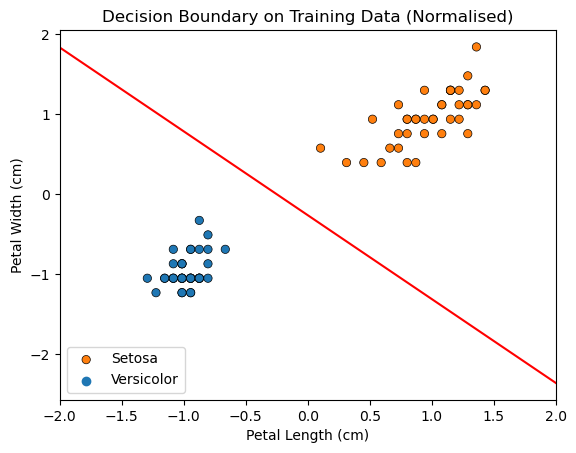

In [19]:
decision_boundary_plotter(model, x_train_norm, y_train)
plt.title('Decision Boundary on Training Data (Normalised)')
# plt.savefig('images/iris_decision_boundary_training.png')
plt.show()

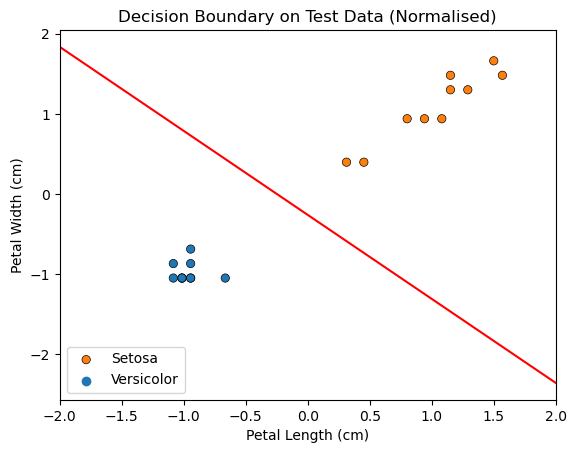

In [20]:
decision_boundary_plotter(model, x_test_norm, y_test)
plt.title('Decision Boundary on Test Data (Normalised)')
# plt.savefig('images/iris_decision_boundary_test.png')
plt.show()

<h3>Second section: Working with <b>make_moons()</b> dataset</h3>

In [21]:
data = datasets.make_moons(n_samples=500, shuffle=True, random_state=3, noise=0.05)

x = data[0]
y = data[1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=3)

#normalising dataset
sc = StandardScaler()
x_train_norm = sc.fit_transform(x_train)
x_test_norm = sc.transform(x_test)

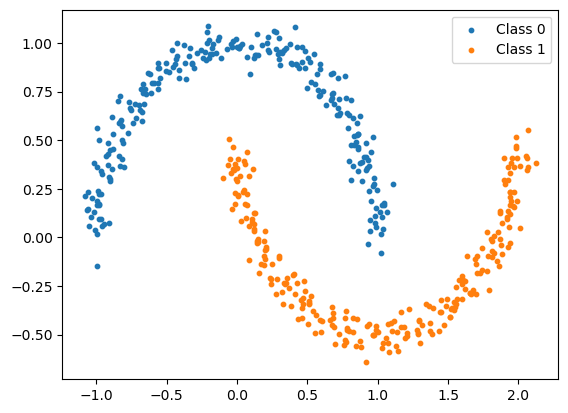

In [22]:
#plotting the training set
x_train_class_0 = x[y == 0]
x_train_class_1 = x[y == 1]
plt.scatter(x_train_class_0[:, 0], x_train_class_0[:, 1], label = 'Class 0', s=10)
plt.scatter(x_train_class_1[:, 0], x_train_class_1[:, 1], label = 'Class 1', s=10)
plt.legend()
# plt.savefig('images/moons_training_set.png')
plt.show()

Training Accuracy: 0.89
Test Accuracy: 0.85


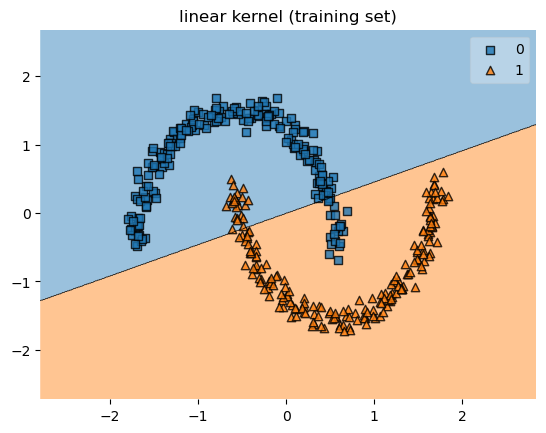

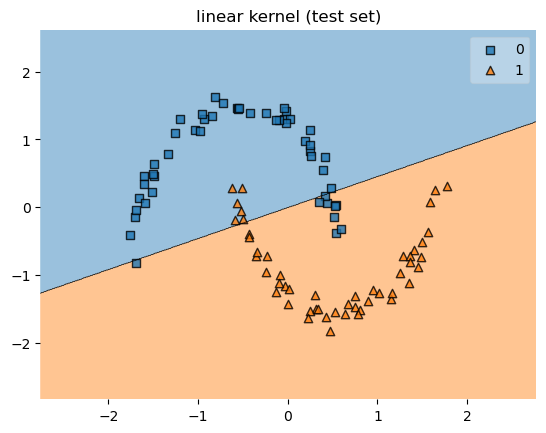

Training Accuracy: 0.8875
Test Accuracy: 0.87


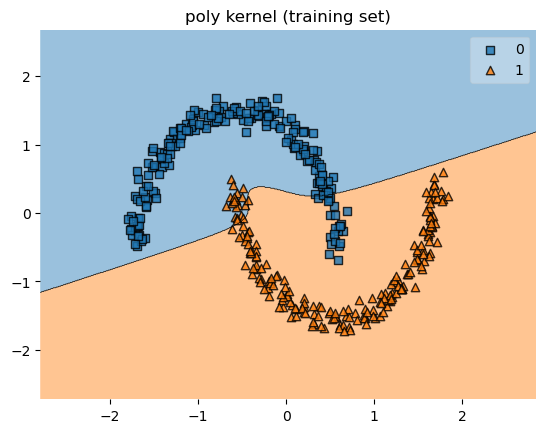

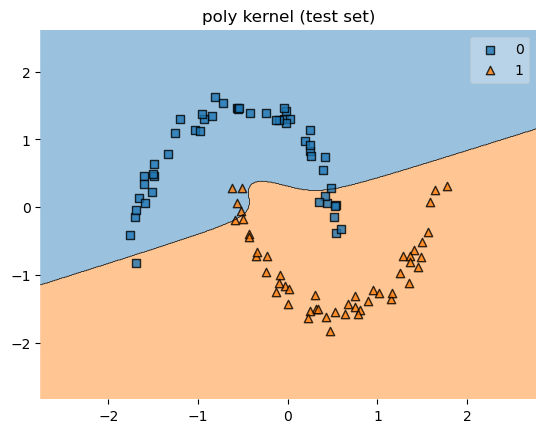

Training Accuracy: 1.0
Test Accuracy: 1.0


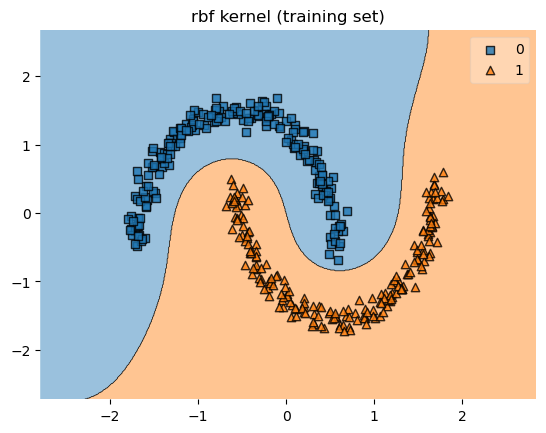

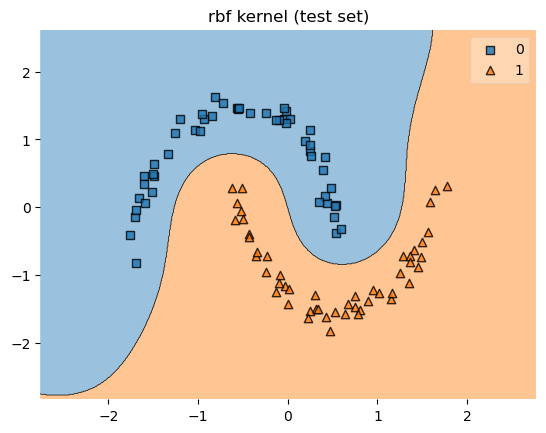

In [23]:
kernels = ['linear', 'poly', 'rbf']

#plotting decision boundaries for different kernels
for val in kernels:
    clf = SVC(kernel=val, random_state=3)
    clf.fit(x_train_norm, y_train)
    print(f'Training Accuracy: {clf.score(x_train_norm, y_train)}')
    print(f'Test Accuracy: {clf.score(x_test_norm, y_test)}')
    plt.figure()
    plot_decision_regions(x_train_norm, y_train, clf)
    plt.title(f'{val} kernel (training set)')
    # plt.savefig(f'images/moons_decision_boundary_{val}_training.png')
    plt.show()

    plt.figure()
    plot_decision_regions(x_test_norm, y_test, clf)
    plt.title(f'{val} kernel (test set)')
    # plt.savefig(f'images/moons_decision_boundary_{val}_test.png')
    plt.show()

In [24]:
#performing randomised search to find best hyperparameters
clf = SVC(kernel='rbf', random_state=3)
param_distributions = {'C': stats.uniform(0, 1),
                       'gamma': stats.uniform(0, 1)}

rcv = RandomizedSearchCV(estimator=clf,
                         param_distributions=param_distributions,
                         refit=True,
                         n_iter=100,
                         n_jobs=-1,
                         cv=10,
                         scoring='accuracy',
                         random_state=3)

rcv.fit(x_train_norm, y_train)
rcv.best_params_

{'C': 0.5507979025745755, 'gamma': 0.7081478226181048}

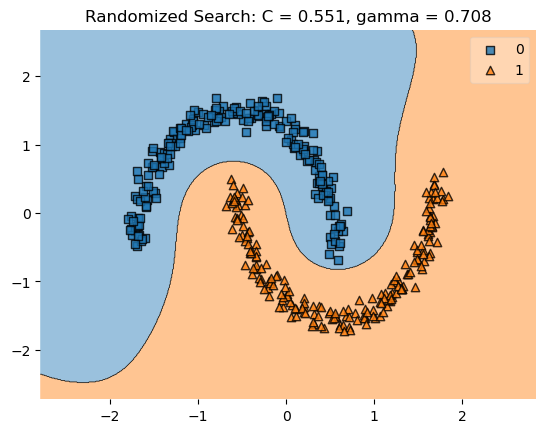

In [25]:
#plotting the best model
best_clf = rcv.best_estimator_
plot_decision_regions(x_train_norm, y_train, best_clf)
plt.title(f"Randomized Search: C = {round(rcv.best_params_['C'], 3)}, gamma = {round(rcv.best_params_['gamma'], 3)}")
# plt.savefig(f"images/rcv_c055_gamma708.png")
plt.show()

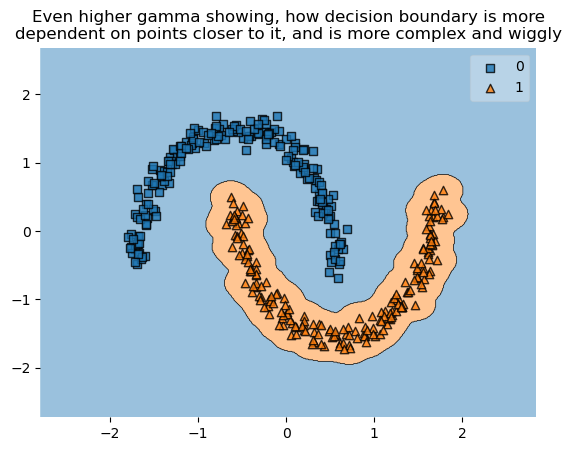

In [26]:
#this section is used to obtain the graphs in the last of the report, where i comapred high and low values of C and gamma. Can be ignored
clf = SVC(kernel='rbf', C=1, gamma=100, random_state=3)
clf.fit(x_train_norm, y_train)

plot_decision_regions(x_train_norm, y_train, clf)
plt.title('Even higher gamma showing, how decision boundary is more\ndependent on points closer to it, and is more complex and wiggly')
# plt.savefig('images/higher_gamma.png')
plt.show()